# Exercise 2
Visualize and clusterize the data in the file x_12d.dat (N=600 samples, L=12 dimensions),
which also has labels for checking the performances (y_12d.dat).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname, fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

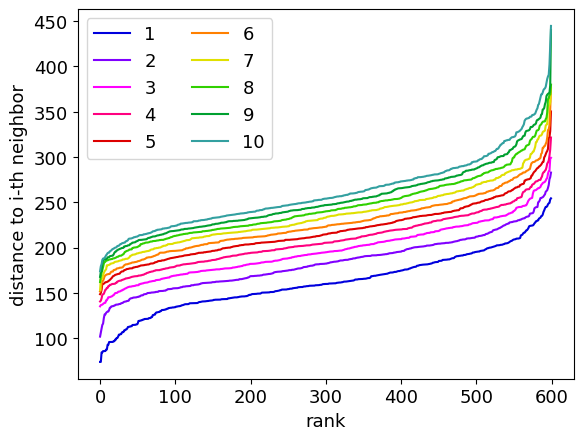

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
distances, ind = nbrs.kneighbors(x)
dd=distances.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i%10-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ", mean_min_dist)

Functions provided during the lecture:

In [4]:
# functions provided in the lecture notebook
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

## 2.1 “eps” (ε) and “minPts” ($m_P$) in DBSCAN algorithm for clustering

Refine the grid with more values of ε and $m_P$ and plot a heat-map
showing the normalized mutual information (NMI) between true
and predicted clusters, similar to the one on the right.
Is the high NMI region showing a correlation between ε and $m_P$?

Note: In the lesson we have looked at the typical distance between
a point and its closest neighbor, but this does not say what the
typical distance is from the 2nd, 3rd , …, $m_P$-neighbor.
The plots of ranked distances to the i-th neighbor might also help
choose the ε for a given $i=m_P$ .

In [5]:
import time
    
# define eps and mp grid
# based on typical min. distance between points
eps_range = np.arange(100, 800, 10)
min_sample_range = np.arange(5, 205, 5)

# list for results
nmi_results = []

# time the process for fun :D
ts = time.time()

for eps in eps_range:
    for mp in min_sample_range:

        # define & train model
        model = DBSCAN(eps=eps, min_samples=mp)
        model.fit(x)
        
        y_hat = model.labels_

        #calculate NMI
        nmi=NMI(y_hat, y)
        # append to results as dict
        nmi_results.append({"eps": eps, "mp": mp, "nmi": nmi})      
        
print("calculation took {:.2f}s".format(time.time()-ts))

calculation took 89.10s


Text(66.72222222222221, 0.5, '$\\epsilon$')

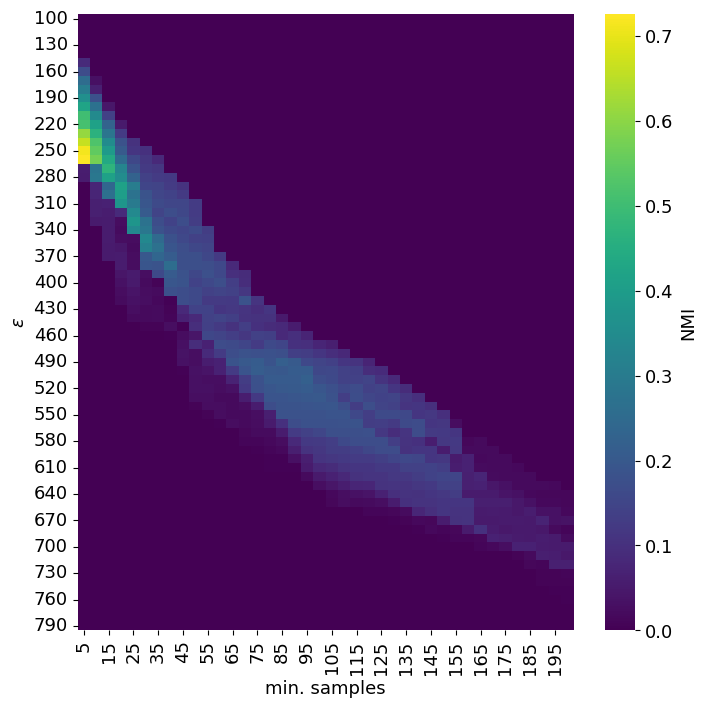

In [7]:
import pandas as pd
import seaborn as sns

# convert to pandas dataframe
df = pd.DataFrame(nmi_results)

# plot heatmap
plt.figure(figsize=(8,8))
sns.heatmap(df.pivot(columns="mp", index="eps", values="nmi"),
            cmap="viridis",
            cbar_kws={'label': 'NMI'})
plt.xlabel("min. samples")
plt.ylabel("$\epsilon$")

The high-NMI region does indeed appear to show a correlation between $\varepsilon$ and $m_p$. $\varepsilon$ describes the maximum distance between points to be counted as neighbours, and $m_p$ is the minimum number of neighbours within $\varepsilon$ a point must have to be classified as a core point inside a cluster. Consider 2 cases:
1. **$\varepsilon$ too low / $m_p$ too high:**  Very few/no points are reachable or recognized as core points by the DBSCAN algorithm, so most points are interpreted as not reachable and thus noise points.
2. **$\varepsilon$ too high / $m_p$ too low:** Many (or in the worst case, all) points are classified as core points or are (directly) reachable, so the algorithm could interpret data as one large cluster (or very few, very large clusters).
  
The plot shows that better results can be a achieved with a sensible ratio between $\varepsilon$ and $m_P$, and that the range of successful combinations can be estimated well using the plot of typical minimum distances from above. It can also be seen that here, the highest NMI is achieved for lower values of $\varepsilon$ and $m_p$, which demonstrates that not only the ratio between the parameters matters. The best choices for $\varepsilon$ and $m_p$ depend on the given data, and should be carefully tuned for the algorithm to succeed.